In [1]:
# Importing libraries
import os 
import pandas as pd 
import numpy as np
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yaml 

In [2]:
# Importing path from src
import sys
import yaml

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

from src.utils.config import RAW_DATA_DIR, BASE_DIR, RAW_DATA_STOCK_DIR,PROCESSED_DATA_STOCK_DIR
from src.utils.log_handler import logger
from src.utils.exception import StockPulseException

with open(os.path.join(BASE_DIR, "config/stock_config.yaml"), "r") as file:
    SETTINGS = yaml.safe_load(file)
logger.info("Succesfully imported the file")

In [3]:
#Loading the dataframe
stock_data= pd.read_csv(os.path.join(RAW_DATA_STOCK_DIR, f'{datetime.now().strftime("%Y-%m-%d")}_raw_data.csv'))

In [4]:
# Having a look at top 5 values of dataframe
stock_data.head()

,datetime,open,high,low,close,volume
0,2025-08-22 14:55:00,1202.33997,1202.48584,1202.04175,1202.09998,4232
1,2025-08-22 14:56:00,1201.79004,1201.79004,1201.79004,1201.79004,461
2,2025-08-22 14:57:00,1202.00000,1202.60986,1202.00000,1202.60986,6330
3,2025-08-22 14:58:00,1202.25000,1202.32500,1202.16000,1202.30000,220
4,2025-08-22 14:59:00,1202.27000,1202.27500,1202.27000,1202.27500,12


In [5]:
# Looking at the bottom 5 values of the dataframe
stock_data.tail()

,datetime,open,high,low,close,volume
3495,2025-09-05 15:55:00,1243.19995,1244.02246,1243.03003,1243.04004,8448
3496,2025-09-05 15:56:00,1243.27002,1243.45996,1242.85999,1243.09497,15134
3497,2025-09-05 15:57:00,1242.84998,1243.75000,1242.65002,1243.75000,32626
3498,2025-09-05 15:58:00,1243.37000,1243.63000,1242.92249,1243.23999,26312
3499,2025-09-05 15:59:00,1243.31494,1244.17004,1242.85498,1244.17004,52242


In [6]:
# Information about the dataset 
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  3500 non-null   object 
 1   open      3500 non-null   float64
 2   high      3500 non-null   float64
 3   low       3500 non-null   float64
 4   close     3500 non-null   float64
 5   volume    3500 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 164.2+ KB


In [7]:
#Changing the datatype 
stock_data['datetime'] = pd.to_datetime(stock_data['datetime'])

In [8]:
# Checking for null values of the volume
stock_data.isnull().sum()

datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [9]:
# AS data is lively taken so it is better to make a assumption that ki sometime there can be chances of null values so let deal with it
# even if it is clean now.

for column, value in stock_data.isnull().sum().squeeze().to_dict().items():
    if value >0:
        if stock_data[column].dtype in ['float64', 'int64']:
            stock_data[column] = stock_data[column].fillna(method="ffill")
            stock_data[column] = stock_data[column].fillna(method='bfill')

            if stock_data[column].isnull().sum() >0:
                stock_data[column] = stock_data[column].fillna(stock_data[column].median())

        else:
            stock_data[column] = stock_data[column].fillna(stock_data[column].mode()[0])


In [10]:
# Checking for update date data type
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  3500 non-null   datetime64[ns]
 1   open      3500 non-null   float64       
 2   high      3500 non-null   float64       
 3   low       3500 non-null   float64       
 4   close     3500 non-null   float64       
 5   volume    3500 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 164.2 KB


In [11]:
# Checking for the presence of duplicated data in dataframe
stock_data.duplicated().sum()

np.int64(0)

In [12]:
# AS data is lively taken so it is better to make a assumption that ki sometime there can be chances of duplicated values so let deal with it
# even if it is clean now.
if stock_data.duplicated().sum()>0:
    stock_data= stock_data.drop_duplicates()

In [13]:
# Renaming the column 
stock_data = stock_data.rename(columns={'datetime':"ds", "close": "y"})


<Axes: ylabel='y'>

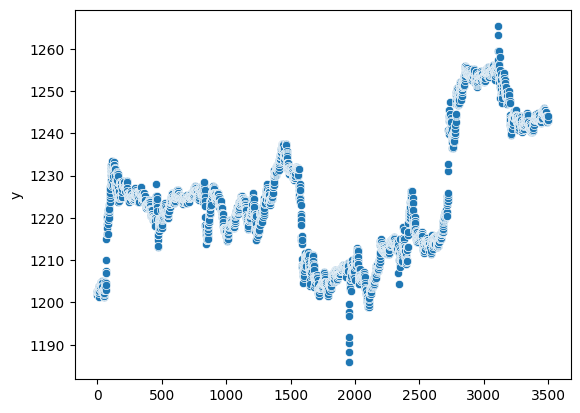

In [14]:
# Checking for the outlier in the target variable 
sns.scatterplot(stock_data['y'])


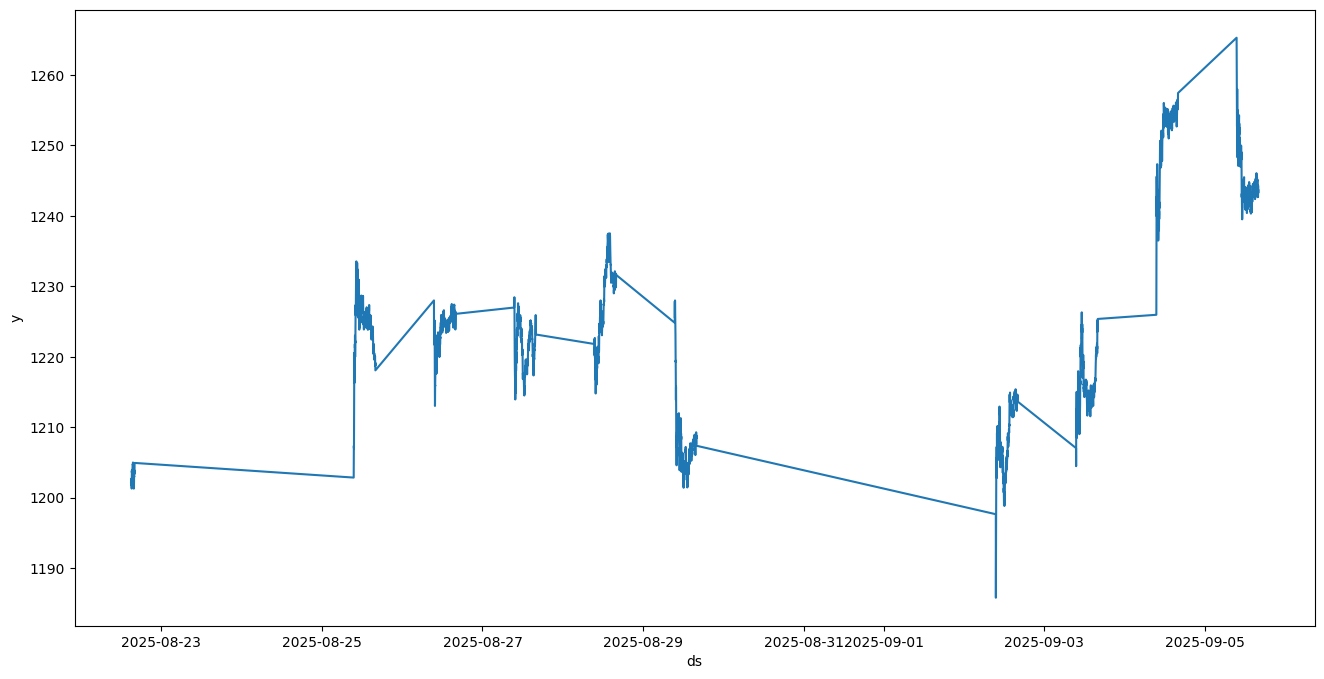

In [15]:
# Checking for the outlier in the target variable 
plt.figure(figsize=(16, 8))
sns.lineplot(data=stock_data, x='ds', y='y')
plt.show()

In [16]:
# Saving the loaded data to local 
import glob

stock_data.to_csv(os.path.join(PROCESSED_DATA_STOCK_DIR, f"{datetime.now().strftime('%Y-%m-%d')}_cleaned_data.csv"), mode='w' , index=False)

keep_file = SETTINGS['data']['keep_days']
for file in glob.glob(os.path.join(PROCESSED_DATA_STOCK_DIR,  "*.csv")):
    file_time= datetime.fromtimestamp(os.path.getmtime(file))
    if (datetime.now() - file_time).days >keep_file:
        os.remove(file)
        print(f"Deleted old file: {file}")